# Adding NEDname to VF catalogs #

- a major component of this is to look up the NED names of the galaxies 
  - this has been much more complicated than I expected...
  - first, I was shut out by NED for submitting too many queries.  One solution suggested by NED people is to add a 1 sec pause between queries.  This does work.  However, with 10k galaxies, it also increases the run time BY A LOT!!!
  - second, NED names are not as clean and clear as you would hope.  
  

- need to include the NEDname in the VF catalog
- I tried to query NED name by position, but I got shut out of NED (to many requests)
  - I added a 1 sec delay, and that worked
  - of course, with 10k sources, this adds at least 10,000s :(
  - not something you want to run and rerun and rerun...
- I also tried downloaded a catalog from NED and matched that to the VF galaxies, but this didn't work
  - the following is the NED query I used to download the catalog

```
        Search by by Parameters
        decmin = -35  ** this is different from first download
        decmax = 75
        ramax = 280.
        ramin = 100.
        vmax = 3300. (units km/s)
        vmin = 500.
        object = Galaxy
        
        RA has to be in hours
        ramin = 6.6666666667
        ramax = 18.666666667

        output = text, ascii, bar separated
        velocity lower limit = -99

        Had to run this on virgo b/c I got locked out of NED.
        can't access the website from any machine in my house!

        Dowloaded text file - there was garbage at top of file (unnecessary info) that I deleted.

        Saved as

        /Users/rfinn/github/Virgo/tables/ned-noprolog-25mar2020.txt
        
```

## Breaking into its own program - get_NEDname.py ##

- input: vf_clean_sample.fits
- output: vf_clean_sample_wNEDname.fits

- this will 


# Why are rows getting reordered?

- the rows in the output file vf_clean_sample_wNEDnames.fits are in a different order

- found out that the join commands sorts the output table according to the join key!!!
- FIX: I made my own function in virgoCommon called myjoinleft, which returns the joined table in the same order as the first input table (the left table)



In [1]:
from astropy.io import fits, ascii
from matplotlib import pyplot as plt
from astropy.table import Table
import os
import numpy as np
%matplotlib inline

In [9]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/get_NEDname.py

found file ned_names.fits.
Using this instead of querying NED


## Looks like query_region is working as expected

- I thought that I was getting really large separations between our RA and DEC and the NEDra,NEDdec because query_region was somehow ignoring the radius parameter, which I had set to 10 arcsec
- however, it looks that function works as expected
- the large offsets all come from galaxies where I searched for the NED counterpart by name

In [10]:
c = SkyCoord(ra=141.54256, dec=33.72057, unit=u.degree, frame='icrs')
t = Ned.query_region(c,radius=10.*u.arcsec,equinox='J2000')
print(t['Separation'])

Separation
  arcmin  
----------
     0.049
     0.043
     0.026
     0.042
     0.114


In [61]:
.114*60


6.84

In [62]:
print(t)

No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1     SDSS J092609.98+334313.8  141.54158 ...               0            0
  2    WISEA J092610.05+334312.4  141.54189 ...               0            0
  3 GALEXASC J092610.15+334315.3  141.54229 ...               0            0
  4     SDSS J092610.15+334311.6   141.5423 ...               4            0
  5    WISEA J092610.59+334318.9  141.54416 ...               0            0


In [120]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/get_NEDname.py

found file ned_names.fits.
Using this instead of querying NED


## calculate distance between RA and DEC input to ned vs NED match

- apparently the radius value input to the NED search by location does not limit the offset of the galaxies it returns!
- not true.  All of the mismatches are sources that we searched for NED counterpart by name
  - so these are an error with NED coordinates.



In [47]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
t = Table(fits.getdata('vf_clean_sample_wNEDname.fits'))
#os.chdir('/home/rfinn/research/Virgo/supersample/')
#t2 = Table(fits.getdata('vf_clean_sample.fits'))

In [48]:
d = np.sqrt((t['RA'] - t['NEDra'])**2 + (t['DEC']-t['NEDdec'])**2)

In [51]:
outlier = (d > 6./60) & (t['NEDra'] != -999) # offsets larger than 30 arcsec
print('number of6utliers = ',sum(outlier))
indices = np.arange(len(t))[outlier]
d2 = Column(d*60,name='separation(amin)')
dum = Table([t['NEDinput'],t['superName'],t['NEDname'],t['RA'],t['NEDra'],t['DEC'],t['NEDdec'],d2])
dum = dum[indices]
dum
#for i in indices:
#    print("{:04d} {:12s} {:12s} {:26s} {:12.8f} {:12.8f} {:12.8f} {:12.8f}".format(i,t['NEDinput'][i],t2['superName'][i],t['NEDname'][i],t2['RA'][i],t['NEDra'][i],t2['DEC'][i],t['NEDdec'][i]))

number of6utliers =  21


NEDinput,superName,NEDname,RA,NEDra,DEC,NEDdec,separation(amin)
str28,str26,str30,float32,float32,float32,float32,float32
NGC6237,NGC6237,NGC 6237,251.59164,251.0314,70.358765,70.63479,37.472866
NSA 60013,NSA 60013,WISEA J112252.73+471251.0,148.02232,170.71977,62.352913,47.21419,1636.9723
NSA 52302,NSA 52302,WISEA J112414.52+563906.7,138.56718,171.06058,57.04442,56.65189,1949.7457
NSA 167153,NSA 167153,SDSS J165705.50+783248.4,167.8274,254.27292,55.66979,78.54669,5365.282
NSA 167671,NSA 167671,WISEA J183837.27+162759.2,167.81009,279.65524,55.66802,16.46631,7110.9775
NSA 51666,NSA 51666,WISEA J082942.42+062317.8,134.77469,127.42676,53.760235,6.38826,2876.3076
NSA 50066,NSA 50066,SDSS J080433.51+241634.5,129.4312,121.13966,51.64175,24.27626,1715.643
NSA 87774,NSA 87774,WISEA J133255.45+351247.3,218.36241,203.2311,4.454122,35.21324,2056.7666
NSA 68838,NSA 68838,WISEA J031854.61+414810.8,185.13748,49.72675,2.9542134,41.80308,8452.401


number of galaxies with offset > 30.0 arcsec =  182


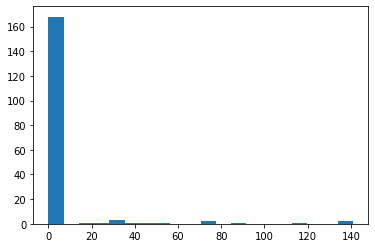

In [45]:
plt.figure()
maxoffset = 30.
dump = plt.hist(d[d>maxoffset/3600],bins=20)
print('number of galaxies with offset > '+str(maxoffset)+' arcsec = ',sum(d > maxoffset/3600))
#plt.set_yscale('log')


# Running the Code with partial NED query #

- this is much better to run in ipython
- leaving it here in case it's useful
- one thing to note is that many sources have multiple NED sources within 10 arcsec

In [22]:
os.chdir('/home/rfinn/research/Virgo/supersample/')
%run ~/github/Virgo/programs/get_NEDname.py

found file ned_names.fits.
Using this instead of querying NED
405 161.9325 11.933611
No. Object Name    RA     DEC   ... Redshift Points Diameter Points Associations
                degrees degrees ...                                             
--- ----------- ------- ------- ... --------------- --------------- ------------
IndexError
oh no - could not find NED name! so sorry... 405
1407 189.9071 10.975749
No. Object Name     RA     ... Redshift Points Diameter Points Associations
                 degrees   ...                                             
--- ----------- ---------- ... --------------- --------------- ------------
  1    VCC 1803  189.90714 ...               8               9            0
1465 149.627 0.04535
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1                  SHOC 289  149.62598 

2879 140.08109 64.080635
No.        Object Name             RA     ... Diameter Points Associations
                                degrees   ...                             
--- -------------------------- ---------- ... --------------- ------------
  1     NGC 2805:[ZBF2015] 018  140.08042 ...               0            0
  2     NGC 2805:[ZBF2015] 022  140.08042 ...               0            0
  3   SDSS J092019.45+640450.1  140.08106 ...               4            0
  4  WISEA J092019.62+640451.0  140.08146 ...               0            0
  5     USNO-B1.0 1540-0162426  140.08202 ...               0            0
  6     NGC 2805:[ZBF2015] 025  140.08292 ...               0            0
  7 SSTSL2 J092020.07+640451.5  140.08367 ...               0            0
2880 234.40211 5.9587755
No.        Object Name             RA     ... Diameter Points Associations
                                degrees   ...                             
--- -------------------------- ---------- ... ----

2919 187.18993 44.864143
No.       Object Name           RA     ... Diameter Points Associations
                             degrees   ...                             
--- ----------------------- ---------- ... --------------- ------------
  1 2MASS J12284495+4451448  187.18731 ...               0            0
  2                NGC 4460  187.18983 ...               6            0
  3 2MASS J12284594+4451533  187.19142 ...               0            0
  4 2MASS J12284594+4451598  187.19145 ...               0            0
  5 2MASS J12284596+4451582  187.19153 ...               0            0
  6 2MASS J12284607+4451554  187.19196 ...               0            0
  7 2MASS J12284618+4451574  187.19242 ...               0            0
2921 113.99946 35.383823
No. Object Name     RA     ... Redshift Points Diameter Points Associations
                 degrees   ...                                             
--- ----------- ---------- ... --------------- --------------- ------------
  

2945 182.13052 15.094801
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1                     VCC 0004  182.13052 ...               6            0
  2    WISEA J120831.41+150542.2  182.13088 ...               0            0
  3 GALEXASC J120831.63+150544.3  182.13182 ...               0            0
  4     SDSS J120831.77+150546.4  182.13242 ...               4            0
2946 184.27315 12.289834
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1 GALEXASC J121705.22+121721.2  184.27175 ...               0            0
  2    WISEA J121705.43+121722.3  184.27266 ...               0            0
  3      2MASS J12170554+1

2965 208.92152 59.460674
No.  Object Name      RA     ... Redshift Points Diameter Points Associations
                   degrees   ...                                             
--- ------------- ---------- ... --------------- --------------- ------------
  1 SBS 1354+597B   208.9216 ...               0               4            1
2966 209.19685 -4.6931334
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J135647.17-044134.4  209.19667 ...               0            0
2967 210.89261 -10.151354
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1                   IC 4358  210.89242 ...               6            0
  2 WISEA J140334.4

2985 236.5322 59.170277
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J154607.74+591012.5  236.53229 ...               4            0
2986 236.60066 59.215363
No. Object Name      RA     ... Redshift Points Diameter Points Associations
                  degrees   ...                                             
--- ------------ ---------- ... --------------- --------------- ------------
  1 SBS 1545+593    236.601 ...               1               4            0
2987 237.234 43.986027
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J154856.07+435908.5  237.23364 ...               4            0
2988 237.75732 23.9945
No.  

3010 152.30266 2.1833882
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J100912.62+021100.2  152.30264 ...               8            0
3012 153.36511 2.203221
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J101327.51+021211.5  153.36464 ...               4            0
3013 154.85704 0.6057112
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J101925.50+003613.1  154.85626 ...               4            0
  2  SDSS J101925.52+003617.3  154.856

3037 190.72542 11.438234
No.          Object Name               RA     ... Diameter Points Associations
                                    degrees   ...                             
--- ------------------------------ ---------- ... --------------- ------------
  1   GALEXASC J124253.59+112618.1   190.7233 ...               0            0
  2 [JPB2009] J190.723662+11.43644  190.72366 ...               0            0
  3 [JPB2009] J190.723953+11.43890  190.72395 ...               0            0
  4 [JPB2009] J190.724774+11.43716  190.72477 ...               0            0
  5                       NGC 4637  190.72541 ...              10            0
  6        2MASS J12425412+1126175  190.72548 ...               0            0
  7      WISEA J124254.17+112616.7  190.72574 ...               0            0
  8 [JPB2009] J190.725993+11.43705  190.72599 ...               0            0
  9 [JPB2009] J190.726330+11.43817  190.72633 ...               0            0
 10 [JPB2009] J190.726790+1

3057 183.75996 13.039646
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J121502.48+130222.7  183.76037 ...               4            0
3058 151.49533 -0.028447593
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1    WISEA J100558.87-000140.8  151.49527 ...               8            0
  2 GALEXMSC J100558.94-000140.4  151.49561 ...               0            0
  3               [ATS2004] 0485    151.496 ...               0            0
  4    WISEA J100559.12-000137.8  151.49635 ...               0            0
3060 199.29944 0.986591
No.         Object Name              RA     ... Diameter Points Associations
           

4871 178.45123 -3.2185593
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J115348.36-031307.2  178.45123 ...               8            0
  2  SDSS J115348.73-031314.2  178.45307 ...               4            0
4872 194.77138 -3.204323
No.       Object Name            RA     ... Diameter Points Associations
                              degrees   ...                             
--- ------------------------ ---------- ... --------------- ------------
  1 SDSS J125904.73-031223.2  194.76972 ...               4            0
  2 SDSS J125905.03-031210.4  194.77099 ...               4            0
  3    LCRS B125630.5-025601  194.77127 ...               4            0
4875 212.85002 -3.1674197
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   

4905 215.55092 -1.8913014
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J142212.10-015331.9  215.55046 ...               0            0
  2 WISEA J142212.13-015326.8  215.55055 ...               0            0
  3  SDSS J142212.16-015328.4  215.55097 ...               8            0
  4  SDSS J142212.23-015321.6  215.55099 ...               4            0
4907 200.82227 -1.8288323
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J132317.25-014947.5  200.82188 ...               0            0
  2   2MASS J13231729-0149514    200.822 ...               4            0
  3  SDSS J132317.33-014943.8  200.82229 ...               4

4944 134.0126 -0.489759
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J085603.01-002923.6  134.01264 ...               4            0
4945 178.55057 -0.4822118
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J115412.06-002856.4  178.55029 ...               3            0
  2               GAMA 559879  178.55104 ...               0            0
4949 146.61899 -0.4343106
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J094628.55-002603.5  146.6

4988 145.32097 0.7711199
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J094117.02+004616.2  145.32093 ...               8            0
4991 228.1322 0.8125837
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J151231.73+004845.5  228.13223 ...               8            0
4992 227.2679 0.8219841
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1   2MASX J15090433+0049185  227.26788 ...              10            0
  2 WISEA J150904.30+004920.9  227.2679

5030 226.38258 1.587694
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J150531.82+013515.6  226.38266 ...               8            0
5031 148.68745 1.609467
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J095445.00+013634.1   148.6874 ...               4            0
5034 151.3233 1.6411072
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1 GALEXASC J100517.41+013824.0  151.32262 ...               0            0
  2     SDSS J100517.58+0138

5072 134.67079 2.1934974
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1 GALEXASC J085840.96+021140.3  134.67069 ...               0            0
  2    WISEA J085841.01+021135.4  134.67077 ...               8            0
  3     SDSS J085840.99+021137.3   134.6708 ...               4            0
  4     SDSS J085841.02+021130.8  134.67094 ...               4            0
5073 168.52196 2.1987417
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J111405.22+021155.4  168.52175 ...               4            0
  2 WISEA J111405.40+021156.9  168.52262 ...               0            0
5076 223.64343 2.343918
No.        Object

5103 193.56622 2.7624078
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1 GALEXASC J125415.81+024548.0   193.5659 ...               0            0
  2    WISEA J125415.88+024544.5   193.5662 ...               4            0
5106 191.03317 3.0061724
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J124407.90+030025.9  191.03294 ...               0            0
  2  SDSS J124407.95+030022.1  191.03316 ...               4            1
  3 WISEA J124408.01+030019.4  191.03339 ...               0            0
  4  SDSS J124408.18+030024.8  191.03411 ...               4            0
5107 217.81892 3.2567103
No.         Object Nam

5149 208.7688 5.1894975
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1    WISEA J135504.45+051121.7  208.76879 ...               4            0
  2 GALEXASC J135504.56+051119.3  208.76904 ...               0            0
5150 177.77008 5.24615
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J115104.84+051445.8  177.77008 ...               8            0
  2  SDSS J115105.24+051447.1  177.77186 ...               4            0
5151 219.93532 5.353347
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ----------------------

5175 183.59792 6.7642236
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J121423.42+064547.3  183.59762 ...               0            0
  2                  VCCA 006  183.59787 ...               4            0
  3 WISEA J121423.56+064553.1  183.59817 ...               0            0
5176 137.10005 6.951489
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1    WISEA J090823.99+065706.0  137.10006 ...               8            0
  2 GALEXASC J090824.03+065707.8  137.10014 ...               0            0
5178 184.57487 7.1280317
No.        Object Name            RA     ... Diameter Points Associations
                       

5212 178.42838 -1.6598783
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J115342.20-013935.5  178.42591 ...               0            0
  2  SDSS J115342.41-013932.5  178.42675 ...               4            0
  3 WISEA J115342.77-013935.7  178.42839 ...               8            0
5218 184.1611 -1.451742
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1     SDSS J121638.53-012715.8  184.16055 ...               4            0
  2     SDSS J121638.61-012656.8  184.16088 ...               4            0
  3    WISEA J121638.68-012706.0  184.16125 ...               4            0
  4 GALEXMSC J121638.74-012704.1  184.16144 

5271 211.76833 10.712626
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J140704.36+104245.2  211.76821 ...               4            0
  2 WISEA J140704.48+104245.8  211.76883 ...               0            0
5276 119.55172 11.020592
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J075812.43+110114.1  119.55183 ...               4            0
  2  SDSS J075812.56+110106.3  119.55236 ...               4            0
  3  SDSS J075812.57+110121.2  119.55241 ...               4            0
5279 151.54512 11.100344
No.        Object Name            RA     ... Diameter Points Associations
                               degree

5337 175.94214 13.707567
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J114346.09+134227.1  175.94216 ...              10            0
  2 WISEA J114346.40+134230.8  175.94334 ...               0            0
5339 182.97441 13.808377
No. Object Name     RA     ... Redshift Points Diameter Points Associations
                 degrees   ...                                             
--- ----------- ---------- ... --------------- --------------- ------------
  1    VCCA 003  182.97438 ...               7               8            0
5341 157.92006 13.834928
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J103140.62+135014.3

5370 169.45164 16.640049
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J111748.37+163825.2  169.45169 ...               4            0
5372 169.46167 16.821123
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J111750.80+164915.7  169.46146 ...               0            0
5374 176.16966 16.899632
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J114440.72+165358.2  176.16965 ...               4            0
5382 163.7778 17.462652
No.        Ob

5454 138.27858 20.367952
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J091306.87+202204.7  138.27871 ...               0            0
5455 126.074776 20.513716
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J082417.95+203050.0  126.07479 ...               8            0
  2  SDSS J082418.59+203045.4  126.07749 ...               4            0
5456 166.35403 20.600758
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J110524.74+203605.1  166.3

5523 172.29622 22.29481
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1    WISEA J112911.11+221740.7  172.29621 ...               0            0
  2 GALEXASC J112911.26+221738.0  172.29692 ...               0            0
5526 206.5624 22.45823
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J134614.98+222729.1  206.56249 ...               0            0
5528 214.5593 22.557112
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J141814.28+22332

5588 182.3382 25.200756
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J120921.19+251202.5  182.33823 ...               4            0
5590 126.79591 25.243162
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J082710.67+251433.9  126.79448 ...               0            0
  2  SDSS J082711.01+251435.2  126.79592 ...               8            0
  3 WISEA J082711.19+251436.6  126.79665 ...               0            0
5594 136.5038 25.469831
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------

5630 193.14062 -1.7302307
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J125233.74-014348.6  193.14062 ...               8            0
  2 WISEA J125233.79-014349.7   193.1408 ...               0            0
5633 158.08888 28.420177
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J103221.25+282511.4  158.08857 ...               4            1
  2 WISEA J103221.31+282511.7  158.08893 ...               0            0
  3  SDSS J103221.37+282513.3  158.08908 ...               0            1
5634 250.0923 28.471565
No.        Object Name            RA     ... Diameter Points Associations
                               degree

5666 192.10884 31.721786
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J124826.00+314319.0  192.10835 ...               0            0
  2  SDSS J124826.11+314318.5  192.10882 ...               4            0
5667 203.26248 31.816853
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J133302.81+314903.4  203.26173 ...               0            0
  2   2MASS J13330291+3149013  203.26246 ...               4            0
  3 WISEA J133303.13+314858.3  203.26308 ...               0            0
5668 186.52513 31.859753
No.         Object Name              RA     ... Diameter Points Associations
                                  

5700 216.36334 33.887947
No.        Object Name             RA     ... Diameter Points Associations
                                degrees   ...                             
--- -------------------------- ---------- ... --------------- ------------
  1 SSTSL2 J142527.14+335318.8   216.3631 ...               0            0
  2  WISEA J142527.26+335316.5  216.36333 ...               4            0
  3   SDSS J142527.47+335316.9  216.36447 ...               4            0
  4 SSTSL2 J142527.49+335310.2  216.36458 ...               0            0
  5  SDWFS J142527.91+335316.7   216.3663 ...               0            0
5703 221.33438 34.33002
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J144520.30+341948.0  221.33433 ...               8            0
  2  SDSS J144520.53+341949.1  221.33556 ...           

5729 174.56961 36.889553
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J113816.70+365322.5  174.56963 ...               4            0
5732 217.0732 37.197178
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J142817.60+371150.4  217.07317 ...               4            0
5735 207.06342 37.70692
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J134815.22+374225.6   207.0635 ...               8            0
5736 207.4591 37.730732
No.        Obje

5783 192.03069 27.19255
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J124806.86+271132.0  192.02862 ...               0            0
  2  SDSS J124807.47+271132.7  192.03113 ...               4            0
  3 WISEA J124807.57+271130.7  192.03157 ...               0            0
5787 200.27766 38.98795
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J132106.61+385916.0  200.27763 ...               4            0
5789 173.97888 39.044655
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------

5813 170.77904 39.95671
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1    WISEA J112307.03+395724.3  170.77902 ...               8            0
  2 GALEXASC J112307.04+395723.1  170.77937 ...               0            0
  3     SDSS J112307.16+395723.2  170.77983 ...               3            0
  4    WISEA J112307.52+395719.5  170.78135 ...               0            0
5814 207.67786 40.03565
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J135042.15+400201.1  207.67564 ...               4            0
  2 WISEA J135042.70+400208.4  207.67783 ...               4            0
5816 170.40256 40.156094
No.        Object 

5847 145.92911 41.569164
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J094342.92+413407.2  145.92884 ...               0            0
  2  SDSS J094342.97+413408.9  145.92904 ...               8            0
5848 186.76237 41.57317
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J122702.19+413424.8  186.75909 ...               4            0
  2  SDSS J122702.97+413423.3  186.76237 ...               4            0
  3 WISEA J122703.24+413415.1  186.76351 ...               0            0
5849 186.0468 41.58112
No.        Object Name            RA     ... Diameter Points Associations
                               degrees  

5875 112.43768 43.745846
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J072944.31+434439.8  112.43463 ...               4            0
  2  SDSS J072944.90+434436.4  112.43712 ...               3            0
  3  SDSS J072944.91+434454.0  112.43713 ...               4            0
  4 WISEA J072945.06+434445.2  112.43775 ...               4            0
  5  SDSS J072945.32+434453.1  112.43885 ...               4            0
5877 244.61295 43.942528
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J161827.11+435632.7  244.61297 ...               8            0
5878 238.28926 44.04706
No.        Object Name            RA  

5917 125.56574 46.691776
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J082215.81+464130.5  125.56578 ...               6            0
  2  SDSS J082216.71+464128.2  125.56965 ...               4            0
5918 202.15065 46.767815
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1 GALEXMSC J132836.07+464556.8   202.1503 ...               0            0
  2    WISEA J132836.15+464604.0  202.15066 ...               8            0
  3    WISEA J132836.40+464559.6  202.15169 ...               0            0
5919 161.94626 46.879326
No.        Object Name            RA     ... Diameter Points Associations
                   

5944 197.64032 48.279846
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J131032.73+481646.7  197.63639 ...               4            0
  2 WISEA J131033.56+481649.0  197.63986 ...               0            0
  3   2MASX J13103365+4816481   197.6403 ...               6            0
  4 WISEA J131033.80+481644.9  197.64084 ...               0            0
  5  SDSS J131034.54+481652.2  197.64396 ...               4            0
5945 178.13934 48.293045
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J115233.44+481735.4  178.13933 ...               4            0
5947 173.428 48.334675
No.        Object Name            RA   

5977 218.8392 50.2865
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J143521.41+501711.5  218.83921 ...               4            0
5978 176.27611 50.300735
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J114506.25+501802.4  176.27608 ...               4            0
  2 WISEA J114506.54+501800.2  176.27726 ...               0            0
  3  SDSS J114506.68+501759.2  176.27785 ...               4            0
5979 142.15588 50.3255
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- .

6007 218.08603 53.43898
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J143220.71+532619.3  218.08604 ...               8            0
6009 167.08302 53.607697
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J110819.79+533626.4   167.0823 ...               4            0
  2  SDSS J110819.88+533627.3  167.08308 ...               4            0
  3 WISEA J110820.42+533628.1   167.0851 ...               0            0
6011 168.43169 53.646805
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- --------

6049 176.64192 55.821365
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J114633.26+554918.5   176.6386 ...               0            0
  2 WISEA J114634.08+554917.4  176.64195 ...               8            0
6050 232.71584 55.888107
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J153051.79+555317.1   232.7158 ...               0            0
  2 WISEA J153052.00+555316.9   232.7167 ...               0            0
  3  SDSS J153052.12+555316.1  232.71718 ...               4            0
6053 205.12457 56.24882
No.        Object Name            RA     ... Diameter Points Associations
                               degrees

6092 214.62767 58.18411
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J141830.62+581102.7  214.62771 ...               8            0
6093 187.81108 58.188324
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J123114.29+581116.2  187.80957 ...               4            0
  2 WISEA J123114.67+581117.7  187.81104 ...               4            0
6094 229.61272 58.44973
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J151826.99+582657.6  229.6124

No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J134811.94+600503.7  207.04893 ...               0            0
  2  SDSS J134811.79+600506.8  207.04914 ...               8            0
  3  SDSS J134812.04+600502.0  207.05019 ...               4            0
6129 173.77808 60.10525
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J113506.67+600618.5  173.77738 ...               4            0
6130 207.72398 60.141785
No.        Object Name             RA     ... Diameter Points Associations
                                degrees   ...                             
--- -------------------------- ---------- ... ---------------

6162 157.47195 63.30832
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J102953.30+631829.9  157.47191 ...               8            0
6163 190.92778 63.361214
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J124342.66+632140.3  190.92779 ...               8            0
6164 190.53368 63.390327
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J124207.50+632319.1  190.53126 ...               4            0
  2    2MASXi J1242083+632324  190.533

6195 132.41776 35.19422
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J084940.10+351139.3  132.41709 ...               0            0
  2  SDSS J084940.33+351137.8  132.41805 ...               4            0
  3 WISEA J084940.46+351134.6  132.41861 ...               0            0
  4 WISEA J084940.50+351147.1  132.41878 ...               0            0
  5  SDSS J084940.93+351135.6  132.42058 ...               4            0
6197 256.43912 43.48025
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J170545.26+432850.3  256.43883 ...               4            0
6207 230.492 57.31049
No. Object Name     RA     ... Redshift Po

6396 262.5694 62.42681
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J173016.64+622536.3  262.56939 ...               8            0
6397 207.62842 62.446964
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1                  SHOC 437  207.62842 ...               4            0
  2 WISEA J135031.02+622648.4  207.62928 ...               0            0
6398 206.38115 62.659313
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J134530.62+623929.5  206.3775

6494 150.61282 2.1668675
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1               COSMOS 1507588  150.61137 ...               0            0
  2   SSTSL2 J100226.82+021001.5  150.61175 ...               0            0
  3               COSMOS 1507625  150.61239 ...               0            0
  4    WISEA J100227.11+020959.9  150.61308 ...               0            0
  5 GALEXMSC J100227.21+021002.7  150.61339 ...               0            0
  6               COSMOS 1507620  150.61345 ...               0            0
  7               zCOSMOS 822307  150.61347 ...               0            0
  8               COSMOS 1507628  150.61388 ...               0            0
  9               COSMOS 1507626  150.61419 ...               0            0
6500 159.03226 -1.4111
No.        Object Name      

6572 157.97562 12.927325
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1     SDSS J103153.47+125539.5  157.97281 ...               4            1
  2     SDSS J103153.66+125539.9  157.97361 ...               4            1
  3 GALEXASC J103153.70+125542.2  157.97378 ...               0            0
  4                   AGC 202015  157.97417 ...               0            5
  5 GALEXMSC J103153.86+125533.8  157.97443 ...               0            0
  6    WISEA J103153.92+125533.4  157.97472 ...               4            1
  7     SDSS J103154.05+125538.1  157.97524 ...               4            1
  8    WISEA J103154.34+125540.0  157.97642 ...               0            0
6573 165.7579 8.048325
No.         Object Name              RA     ... Diameter Points Associations
                            

6876 128.11203 29.644894
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1    WISEA J083226.44+293843.6  128.11019 ...               0            0
  2 GALEXASC J083226.61+293836.7  128.11088 ...               0            0
  3    WISEA J083226.77+293850.9  128.11156 ...               0            0
  4     SDSS J083226.88+293841.1  128.11202 ...               0            0
  5    WISEA J083227.09+293842.3  128.11291 ...               0            0
6881 129.0398 3.1009266
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1 GALEXMSC J083609.58+030603.9  129.03993 ...               0            0
  2     SDSS J083610.04+030

7071 153.85823 64.63562
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J101525.86+643808.0  153.85777 ...               0            0
  2  SDSS J101526.49+643808.9  153.86046 ...               4            0
7089 155.91405 12.62374
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J102339.22+123729.0  155.91342 ...               0            0
  2  SDSS J102339.36+123725.5    155.914 ...               4            0
  3 WISEA J102339.56+123722.7  155.91485 ...               0            0
7113 158.34177 21.594736
No.        Object Name            RA     ... Diameter Points Associations
                               degrees 

7454 184.1802 24.718431
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J121643.23+244306.4  184.18017 ...               4            0
  2 WISEA J121643.59+244258.1  184.18165 ...               0            0
  3 WISEA J121643.81+244310.3  184.18255 ...               0            0
7475 184.78172 7.6342363
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J121907.39+073756.2  184.78079 ...               0            0
  2 WISEA J121907.50+073803.2  184.78125 ...               0            0
  3  SDSS J121907.71+073802.5  184.78216 ...               8            0
7493 185.48276 17.681278
No.        Object Name            RA  

7651 204.02365 32.139584
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J133605.63+320821.6  204.02328 ...               0            0
  2  SDSS J133605.64+320827.3  204.02353 ...               4            0
  3 WISEA J133605.78+320829.4  204.02408 ...               0            0
7672 206.95271 40.488564
No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1  SDSS J134748.44+402925.7  206.95184 ...               4            0
  2 WISEA J134748.92+402916.1  206.95387 ...               4            0
7765 215.88634 21.520027
No.        Object Name            RA     ... Diameter Points Associations
                               degree

No.        Object Name            RA     ... Diameter Points Associations
                               degrees   ...                             
--- ------------------------- ---------- ... --------------- ------------
  1 WISEA J123115.08+102627.0  187.81342 ...               4            0
9208 194.99489 28.097754
No.          Object Name               RA     ... Diameter Points Associations
                                    degrees   ...                             
--- ------------------------------ ---------- ... --------------- ------------
  1      WISEA J125958.72+280551.6  194.99476 ...               4            0
  2 [APS2006] J194.994965+28.09813  194.99497 ...               0            0
9212 197.05125 29.088243
No.         Object Name              RA     ... Diameter Points Associations
                                  degrees   ...                             
--- ---------------------------- ---------- ... --------------- ------------
  1   SSTSL2 J130811.61+2905